In [123]:
import json
import pandas as pd
from tabulate import tabulate
from collections import defaultdict
from collections import Counter

In [124]:
with open(".\quality\sampled_records.json", 'r') as file:
    responses = json.load(file)

In [125]:
len(responses)

401

In [84]:
# with open(".\quality\quality_responses.json", 'r') as file:
#     responses = json.load(file)

# Utils

In [126]:
import json
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import matplotlib.patches as mpatches


from tabulate import tabulate
from collections import defaultdict
from collections import Counter



In [127]:
# Mapping from raw model names to clean display names
name_map = {
    'Meta-Llama-3.1-8B-Instruct-Turbo': 'Llama-3.1-8B',
    'Qwen2.5-7B-Instruct-Turbo': 'Qwen2.5-7B',
    'Llama-4-Scout-17B-16E-Instruct': 'Llama-4-Scout-17B',
    'Llama-4-Maverick-17B-128E-Instruct-FP8': 'Llama-4-Maverick-17B',
    'DeepSeek-V3': 'DeepSeek-V3-37B',
    'Qwen2.5-72B-Instruct-Turbo': 'Qwen2.5-7B'
}

In [128]:
def clean_preference_results(preference_result_loss, preference_result_win, pref_results_third_party, models_to_remove):
    # Clean first list (losses)
    preference_result_loss_cleaned = [
        record for record in preference_result_loss
        if record['evaluator'] not in models_to_remove and record['evaluatee'] not in models_to_remove
    ]

    # Clean second list (wins)
    preference_result_win_cleaned = [
        record for record in preference_result_win
        if record['evaluator'] not in models_to_remove and record['evaluatee'] not in models_to_remove
    ]

    # Clean third list (third-party results)
    pref_results_third_party_cleaned = [
        record for record in pref_results_third_party
        if record['judge_model'] not in models_to_remove
        and record['correct_answer_model'] not in models_to_remove
        and record['wrong_answer_model'] not in models_to_remove
    ]

    return preference_result_loss_cleaned, preference_result_win_cleaned, pref_results_third_party_cleaned

In [129]:
def average_metrics_across_models(data_stack):
    averaged_data = {}
    for condition, metrics in data_stack.items():
        averaged_metrics = {}
        for key, values in metrics.items():
            avg_value = sum(values) / len(values)
            averaged_metrics[key] = avg_value
        averaged_data[condition] = averaged_metrics
    return averaged_data

In [178]:
import pandas as pd
from collections import defaultdict

def classify_vote(forward, backward):
    if forward == '1' and backward == '2':
        return 'A'
    elif forward == '2' and backward == '1':
        return 'B'
    else:
        return 'amb'

def track_prediction_changes_self_eval_percentage(pref_original, *pref_lists, perturbation_names=None):
    # Validate inputs
    if not pref_lists:
        raise ValueError("Must provide at least one perturbation list")
    if perturbation_names and len(perturbation_names) != len(pref_lists):
        raise ValueError("Number of perturbation names must match number of perturbation lists")

    # Use default names if none provided
    if not perturbation_names:
        perturbation_names = [f'Perturb {i+1}' for i in range(len(pref_lists))]

    # Helper to build lookup for original predictions
    def build_lookup(data):
        lookup = {}
        for r in data:
            key = (r['evaluator'], r['evaluatee'], r['pid'])
            vote = classify_vote(r['forward_comparison'], r['backward_comparison'])
            lookup[key] = vote
        return lookup

    # Build original predictions lookup
    original_lookup = build_lookup(pref_original)

    # Function to count transitions per initial state
    def count_transitions(data):
        transitions = defaultdict(lambda: defaultdict(int))
        for r in data:
            key = (r['evaluator'], r['evaluatee'], r['pid'])
            orig_vote = original_lookup.get(key, 'amb')
            new_vote = classify_vote(r['forward_comparison'], r['backward_comparison'])
            transitions[orig_vote][new_vote] += 1
        return transitions

    # Count transitions for each perturbation
    all_transitions = [count_transitions(perturb_data) for perturb_data in pref_lists]

    # Build a DataFrame for each perturbation
    all_initial_states = ['A', 'B', 'amb']
    all_end_states = ['A', 'B', 'amb']
    result_dict = {}

    for perturb_name, transitions in zip(perturbation_names, all_transitions):
        # Dynamically build the column names for each initial state
        columns = []
        for s1 in all_initial_states:
            for s2 in all_end_states:
                columns.append(f"{s1}→{s2}")

        df = pd.DataFrame(0, index=all_initial_states, columns=columns)
        for start in all_initial_states:
            total = sum(transitions[start].values())
            if total > 0:
                for end in all_end_states:
                    count = transitions[start][end]
                    df.loc[start, f"{start}→{end}"] = (count / total) * 100
        result_dict[perturb_name] = df.round(2)

    # Combine into a multi-level column DataFrame
    combined_df = pd.concat(result_dict.values(), axis=1, keys=result_dict.keys())

    return combined_df

# Example usage:
# combined_percentage_df_self_eval = track_prediction_changes_self_eval_percentage(
#     pref_original, pref_perturb_A, pref_perturb_B, pref_paraphrase_B)
# print(combined_percentage_df_self_eval)


In [177]:
import pandas as pd
from collections import defaultdict

def classify_vote(forward, backward):
    if forward == '1' and backward == '2':
        return 'A'
    elif forward == '2' and backward == '1':
        return 'B'
    else:
        return 'amb'

def track_prediction_changes_third_party_percentage(pref_original, *pref_lists, perturbation_names=None):
    # Validate inputs
    if not pref_lists:
        raise ValueError("Must provide at least one perturbation list")
    if perturbation_names and len(perturbation_names) != len(pref_lists):
        raise ValueError("Number of perturbation names must match number of perturbation lists")
    
    # Use default names if none provided
    if not perturbation_names:
        perturbation_names = [f'Perturb {i+1}' for i in range(len(pref_lists))]

    # Helper to build lookup for original predictions
    def build_lookup(data):
        lookup = {}
        for r in data:
            key = (r['judge_model'], r['correct_answer_model'], r['wrong_answer_model'], r['pid'])
            vote = classify_vote(r['forward_comparison'], r['backward_comparison'])
            lookup[key] = vote
        return lookup

    # Build original predictions lookup
    original_lookup = build_lookup(pref_original)

    # Function to count transitions per initial state
    def count_transitions(data):
        transitions = defaultdict(lambda: defaultdict(int))
        for r in data:
            key = (r['judge_model'], r['correct_answer_model'], r['wrong_answer_model'], r['pid'])
            orig_vote = original_lookup.get(key, 'amb')
            new_vote = classify_vote(r['forward_comparison'], r['backward_comparison'])
            transitions[orig_vote][new_vote] += 1
        return transitions

    # Count transitions for each perturbation
    transitions_list = [count_transitions(pref_list) for pref_list in pref_lists]

    # Build a DataFrame for each perturbation
    all_initial_states = ['A', 'B', 'amb']
    all_end_states = ['A', 'B', 'amb']
    result_dict = {}

    for perturb_name, transitions in zip(perturbation_names, transitions_list):
        # Dynamically build the column names for each initial state
        columns = []
        for s1 in all_initial_states:
            for s2 in all_end_states:
                columns.append(f"{s1}→{s2}")

        df = pd.DataFrame(0, index=all_initial_states, columns=columns)
        for start in all_initial_states:
            total = sum(transitions[start].values())
            if total > 0:
                for end in all_end_states:
                    count = transitions[start][end]
                    df.loc[start, f"{start}→{end}"] = (count / total) * 100
        result_dict[perturb_name] = df.round(2)

    # Combine into a multi-level column DataFrame
    combined_df = pd.concat(result_dict.values(), axis=1, keys=result_dict.keys())

    return combined_df




In [132]:
import matplotlib.pyplot as plt
import pandas as pd

def plot_transition_comparison(df_self, df_third, condition_name):
    # We know transitions exactly:
    all_transitions = df_self.columns.tolist()

    # For each transition, find which original state it starts from
    # then get the corresponding row in the DataFrame
    self_vals = []
    third_vals = []

    for trans in all_transitions:
        orig_state = trans.split('→')[0]
        self_val = df_self.loc[orig_state, trans]
        third_val = df_third.loc[orig_state, trans]
        self_vals.append(self_val)
        third_vals.append(third_val)

    # X positions
    x_positions = range(len(all_transitions))
    bar_width = 0.35

    # Plot
    fig, ax = plt.subplots(figsize=(18, 7))

    ax.bar(
        [p - bar_width/2 for p in x_positions],
        self_vals,
        width=bar_width,
        label='Self-Eval',
        color='#66c2a5'
    )
    ax.bar(
        [p + bar_width/2 for p in x_positions],
        third_vals,
        width=bar_width,
        label='Third-Party',
        color='#fc8d62',
        hatch='//'
    )

    ax.set_xticks(x_positions)
    ax.set_xticklabels(all_transitions, rotation=45, ha='right', fontsize=10)

    ax.set_title(f"Transition Distribution - {condition_name}", fontsize=16)
    ax.set_ylabel("% of Transitions", fontsize=14)
    ax.set_xlabel("Transition Type", fontsize=14)
    ax.legend()
    ax.grid(axis='y', linestyle='--', alpha=0.7)

    plt.tight_layout()
    plt.show()




In [134]:
from collections import defaultdict
import math

model_names = [
    "Llama-4-Scout-17B-16E-Instruct",
    "Llama-4-Maverick-17B-128E-Instruct-FP8",
    "DeepSeek-V3"
]

def compute_preference_percentages_with_error(pref_results_loss_case, pref_results_win_case,
                                              prefer_a_third_party, error_a_third, prefer_b_third_party, error_b_third,
                                              # prefer_a_third_party_o3mini, error_a_third_party_o3mini, prefer_b_third_party_o3mini, error_b_third_party_o3mini,
                                              condition):
    def compute_grouped_stats(data, model_key):
        stats = defaultdict(lambda: {'A': 0, 'B': 0, 'total': 0})
        for entry in data:
            model = entry[model_key]
            forward = entry['forward_comparison']
            backward = entry['backward_comparison']
            if forward == '1' and backward == '2':
                stats[model]['A'] += 1
            elif forward == '2' and backward == '1':
                stats[model]['B'] += 1
            stats[model]['total'] += 1
        return stats

    def build_stats_with_error(stats):
        prefer_a, prefer_b = [], []
        error_a, error_b = [], []
        for model in model_names:
            A = stats[model]['A']
            B = stats[model]['B']
            total = stats[model]['total']
            if total > 0:
                p_a = A / total
                p_b = B / total
                prefer_a.append(p_a * 100)
                prefer_b.append(p_b * 100)
                error_a.append(math.sqrt(p_a * (1 - p_a) / total) * 100)
                error_b.append(math.sqrt(p_b * (1 - p_b) / total) * 100)
            else:
                prefer_a.append(0.0)
                prefer_b.append(0.0)
                error_a.append(0.0)
                error_b.append(0.0)
        return (prefer_a, error_a), (prefer_b, error_b)

    # Compute stats
    loss_stats = compute_grouped_stats(pref_results_loss_case, 'evaluator')
    win_stats = compute_grouped_stats(pref_results_win_case, 'evaluator')

    # Convert to percentage and error lists
    (prefer_a_self_loss, error_a_loss), (prefer_b_self_loss, error_b_loss) = build_stats_with_error(loss_stats)
    (prefer_a_self_win, error_a_win), (prefer_b_self_win, error_b_win) = build_stats_with_error(win_stats)

    suffix = f"({condition})" if condition else ""
    data_stacked = {
        f"Self-Eval - Loss {suffix}": {
            "Prefer A": prefer_a_self_loss,
            "Prefer A Error": error_a_loss,
            "Prefer B": prefer_b_self_loss,
            "Prefer B Error": error_b_loss
        },
        f"Self-Eval - Win {suffix}": {
            "Prefer A": prefer_a_self_win,
            "Prefer A Error": error_a_win,
            "Prefer B": prefer_b_self_win,
            "Prefer B Error": error_b_win
        },
        f"Third-Party {suffix}": {
            "Prefer A": prefer_a_third_party,
            "Prefer A Error": error_a_third,
            "Prefer B": prefer_b_third_party,
            "Prefer B Error": error_b_third
        }
    }

    return data_stacked


In [135]:
import pandas as pd
import math
from collections import defaultdict

def compute_third_party_accuracy(preference_results, third_party_pref_results, harmful=True, judge_models=None):


    # Initialize stats for each evaluator
    evaluator_stats = defaultdict(lambda: {'total': 0, 'Prefer A': 0, 'Prefer B': 0})

    for pref_record in preference_results:
        evaluator = pref_record['evaluator']
        evaluatee = pref_record['evaluatee']
        pid = pref_record['pid']

        # Define model roles based on harmful flag
        if harmful:
            wrong_model = evaluator
            correct_model = evaluatee
        else:
            wrong_model = evaluatee
            correct_model = evaluator

        # Match third-party records with judge model filtering
        matches = [
            r for r in third_party_pref_results
            if r['wrong_answer_model'] == wrong_model and
               r['correct_answer_model'] == correct_model and
               r['pid'] == pid and
               (r['judge_model'] in judge_models)
        ]

        for r in matches:
            evaluator_stats[evaluator]['total'] += 1
            if r['forward_comparison'] == '2' and r['backward_comparison'] == '1':
                evaluator_stats[evaluator]['Prefer B'] += 1
            elif r['forward_comparison'] == '1' and r['backward_comparison'] == '2':
                evaluator_stats[evaluator]['Prefer A'] += 1

    result = []

    for model in model_names:
        stats = evaluator_stats.get(model, {'total': 0, 'Prefer A': 0, 'Prefer B': 0})
        total = stats['total']
        prefer_a = stats['Prefer A']
        prefer_b = stats['Prefer B']

        if total > 0:
            p_a = prefer_a / total
            p_b = prefer_b / total

            prefer_a_pct = p_a * 100
            prefer_b_pct = p_b * 100

            error_a = math.sqrt(p_a * (1 - p_a) / total) * 100
            error_b = math.sqrt(p_b * (1 - p_b) / total) * 100
        else:
            prefer_a_pct = 0
            prefer_b_pct = 0
            error_a = 0
            error_b = 0

        result.append({
            'Evaluator': model,
            'Prefer A (%)': prefer_a_pct,
            'Prefer A Error (%)': error_a,
            'Prefer B (%)': prefer_b_pct,
            'Prefer B Error (%)': error_b
        })

    return pd.DataFrame(result)


In [136]:
def filter_pref_list(ref_list, target_list, mode='self'):
    filtered_list = []
    
    if mode == 'self':
        # Create set of tuples with key fields for reference list
        ref_keys = {(r['evaluator'], r['evaluatee'], r['pid']) for r in ref_list}
        
        # Only keep target records that match reference keys
        filtered_list = [
            t for t in target_list 
            if (t['evaluator'], t['evaluatee'], t['pid']) in ref_keys
        ]
        
    elif mode == 'third-party':
        # Create set of tuples with key fields for reference list 
        ref_keys = {(r['judge_model'], r['pid'], r['correct_answer_model'], r['wrong_answer_model']) 
                   for r in ref_list}
        
        # Only keep target records that match reference keys
        filtered_list = [
            t for t in target_list
            if (t['judge_model'], t['pid'], t['correct_answer_model'], t['wrong_answer_model']) in ref_keys
        ]
    return filtered_list


In [137]:
judge_models = [
    "Llama-4-Scout-17B-16E-Instruct",
    "Llama-4-Maverick-17B-128E-Instruct-FP8",
    "DeepSeek-V3"
]

# Load Data

## Perturb A

In [138]:
    
with open('.\quality\pref_third_party_all_models_synonym_auto_4w_small_wrong_quality.json', 'r') as file:
    pref_third_party_all_models_synonym_auto_4w_small_wrong_quality = json.load(file)

with open('.\quality\pref_synonym_auto_4w_small_quality_harmful.json', 'r') as file:
    pref_synonym_auto_4w_small_quality_harmful = json.load(file)


In [139]:
len(pref_third_party_all_models_synonym_auto_4w_small_wrong_quality), len(pref_synonym_auto_4w_small_quality_harmful)

(799, 799)

## Perturb B


In [140]:
with open('.\quality\pref_third_party_all_models_synonym_auto_4w_small_right_quality.json', 'r') as file:
    pref_third_party_all_models_synonym_auto_4w_small_right_quality = json.load(file)

with open('.\quality\pref_synonym_auto_4w_small_other_quality_harmful.json', 'r') as file:
    pref_synonym_auto_4w_small_other_quality_harmful = json.load(file)


In [141]:
len(pref_third_party_all_models_synonym_auto_4w_small_right_quality), len(pref_synonym_auto_4w_small_other_quality_harmful)

(802, 802)

## Original

In [142]:
models_to_remove = [
    "Meta-Llama-3.1-8B-Instruct-Turbo",
    "Qwen2.5-7B-Instruct-Turbo",
    "Qwen2.5-72B-Instruct-Turbo"
]

In [143]:
    
with open('.\quality\pref_results_third_party_eval_original.json', 'r') as file:
    pref_results_third_party_eval_original_harmful = json.load(file)

with open('.\quality\pref_other_wrong_quality.json', 'r') as file:
    preference_results_other_wrong = json.load(file)

with open('.\quality\self_pref_quality.json', 'r') as file:
    preference_results = json.load(file)


In [144]:
preference_results, preference_results_other_wrong, pref_results_third_party_eval_original_harmful = clean_preference_results(
    preference_results,
    preference_results_other_wrong,
    pref_results_third_party_eval_original_harmful,
    models_to_remove
)

In [145]:
preference_results = filter_pref_list(pref_synonym_auto_4w_small_other_quality_harmful, preference_results, mode='self')

In [146]:
pref_results_third_party_eval_original_harmful = filter_pref_list(pref_third_party_all_models_synonym_auto_4w_small_right_quality, pref_results_third_party_eval_original_harmful, mode='third-party')

In [147]:
third_party_original_loss = compute_third_party_accuracy(preference_results, pref_results_third_party_eval_original_harmful, harmful=True, judge_models=judge_models)
third_party_pref_a = third_party_original_loss['Prefer A (%)'].tolist()
third_party_pref_b = third_party_original_loss['Prefer B (%)'].tolist()
third_party_pref_a_error = third_party_original_loss['Prefer A Error (%)'].tolist()
third_party_pref_b_error = third_party_original_loss['Prefer B Error (%)'].tolist()

In [148]:
data_stacked_original = compute_preference_percentages_with_error(preference_results,
                                                                  preference_results_other_wrong,
                                                                  third_party_pref_a, third_party_pref_a_error,
                                                                  third_party_pref_b, third_party_pref_b_error,
                                                                  # prefer_a_third_party_o3mini, error_a_third_party_o3mini,
                                                                  # prefer_b_third_party_o3mini, error_b_third_party_o3mini,
                                                                  "original")

## Token-Replacement (wrong) 2 Words

In [149]:
# Load JSON file into a variable
with open('.\quality\pref_third_party_all_models_synonym_auto_wrong_quality.json', 'r') as file:
    pref_third_party_all_models_synonym_auto_wrong_quality = json.load(file)


with open('.\quality\pref_synonym_auto_quality_beneficial.json', 'r') as file:
    pref_synonym_auto_quality_beneficial = json.load(file)

with open('.\quality\pref_synonym_auto_quality_harmful.json', 'r') as file:
    pref_synonym_auto_quality_harmful = json.load(file)

In [150]:
pref_synonym_auto_quality_harmful, pref_synonym_auto_quality_beneficial, pref_third_party_all_models_synonym_auto_wrong_quality = clean_preference_results(
    pref_synonym_auto_quality_harmful,
    pref_synonym_auto_quality_beneficial,
    pref_third_party_all_models_synonym_auto_wrong_quality,
    models_to_remove
)

In [151]:
pref_synonym_auto_quality_harmful = filter_pref_list(pref_synonym_auto_4w_small_other_quality_harmful, pref_synonym_auto_quality_harmful, mode='self')
pref_third_party_all_models_synonym_auto_wrong_quality = filter_pref_list(pref_third_party_all_models_synonym_auto_4w_small_right_quality, pref_third_party_all_models_synonym_auto_wrong_quality, mode='third-party')

In [152]:
third_party_token_loss = compute_third_party_accuracy(pref_synonym_auto_quality_harmful, pref_third_party_all_models_synonym_auto_wrong_quality, harmful=True, judge_models=judge_models)
third_party_pref_a = third_party_token_loss['Prefer A (%)'].tolist()
third_party_pref_b = third_party_token_loss['Prefer B (%)'].tolist()
third_party_pref_a_error = third_party_token_loss['Prefer A Error (%)'].tolist()
third_party_pref_b_error = third_party_token_loss['Prefer B Error (%)'].tolist()

In [153]:
data_stacked_perturb_A = compute_preference_percentages_with_error(pref_synonym_auto_quality_harmful,
                                                                  pref_synonym_auto_quality_beneficial,
                                                                  third_party_pref_a, third_party_pref_a_error,
                                                                  third_party_pref_b, third_party_pref_b_error,
                                                                  # prefer_a_third_party_o3mini, error_a_third_party_o3mini,
                                                                  # prefer_b_third_party_o3mini, error_b_third_party_o3mini,
                                                                  "Perturb A")

## Token-Replacement (right) 2 Words

In [154]:
# # Load JSON file into a variable
with open('.\quality\pref_third_party_all_models_synonym_auto_right_quality.json', 'r') as file:
    pref_third_party_all_models_synonym_auto_right_quality = json.load(file)

with open('.\quality\pref_synonym_auto_other_quality_beneficial.json', 'r') as file:
    pref_synonym_auto_other_quality_beneficial = json.load(file)

with open('.\quality\pref_synonym_auto_other_quality_harmful.json', 'r') as file:
    pref_synonym_auto_other_quality_harmful = json.load(file)

In [155]:
pref_synonym_auto_other_quality_harmful, pref_synonym_auto_quality_beneficial, pref_third_party_all_models_synonym_auto_right_quality = clean_preference_results(
    pref_synonym_auto_other_quality_harmful,
    pref_synonym_auto_other_quality_beneficial,
    pref_third_party_all_models_synonym_auto_right_quality,
    models_to_remove
)

In [156]:
pref_synonym_auto_other_quality_harmful = filter_pref_list(pref_synonym_auto_4w_small_other_quality_harmful, pref_synonym_auto_other_quality_harmful, mode='self')
pref_third_party_all_models_synonym_auto_right_quality = filter_pref_list(pref_third_party_all_models_synonym_auto_4w_small_right_quality, pref_third_party_all_models_synonym_auto_right_quality, mode='third-party')

In [157]:
third_party_token_right_loss = compute_third_party_accuracy(pref_synonym_auto_other_quality_harmful, pref_third_party_all_models_synonym_auto_right_quality, harmful=True, judge_models=judge_models)
third_party_pref_a = third_party_token_right_loss['Prefer A (%)'].tolist()
third_party_pref_b = third_party_token_right_loss['Prefer B (%)'].tolist()
third_party_pref_a_error = third_party_token_right_loss['Prefer A Error (%)'].tolist()
third_party_pref_b_error = third_party_token_right_loss['Prefer B Error (%)'].tolist()



In [158]:
data_stacked_perturb_B = compute_preference_percentages_with_error(pref_synonym_auto_other_quality_harmful,
                                                                  pref_synonym_auto_other_quality_beneficial,
                                                                  third_party_pref_a, third_party_pref_a_error,
                                                                  third_party_pref_b, third_party_pref_b_error,
                                                                  "Perturb B")

## Token-Replacement (wrong) 4 Words

In [159]:
third_party_token_loss = compute_third_party_accuracy(pref_synonym_auto_4w_small_quality_harmful, pref_third_party_all_models_synonym_auto_4w_small_wrong_quality, harmful=True, judge_models=judge_models)
third_party_pref_a = third_party_token_loss['Prefer A (%)'].tolist()
third_party_pref_b = third_party_token_loss['Prefer B (%)'].tolist()
third_party_pref_a_error = third_party_token_loss['Prefer A Error (%)'].tolist()
third_party_pref_b_error = third_party_token_loss['Prefer B Error (%)'].tolist()

In [160]:
data_stacked_perturb_A_4w = compute_preference_percentages_with_error(pref_synonym_auto_4w_small_quality_harmful,
                                                                  pref_synonym_auto_4w_small_quality_harmful,
                                                                  third_party_pref_a, third_party_pref_a_error,
                                                                  third_party_pref_b, third_party_pref_b_error,
                                                                  # prefer_a_third_party_o3mini, error_a_third_party_o3mini,
                                                                  # prefer_b_third_party_o3mini, error_b_third_party_o3mini,
                                                                  "Perturb A 4w")

## Token-Replacement (right) 4 Words

In [161]:
third_party_token_loss = compute_third_party_accuracy(pref_synonym_auto_4w_small_other_quality_harmful, pref_third_party_all_models_synonym_auto_4w_small_right_quality, harmful=True, judge_models=judge_models)
third_party_pref_a = third_party_token_loss['Prefer A (%)'].tolist()
third_party_pref_b = third_party_token_loss['Prefer B (%)'].tolist()
third_party_pref_a_error = third_party_token_loss['Prefer A Error (%)'].tolist()
third_party_pref_b_error = third_party_token_loss['Prefer B Error (%)'].tolist()

In [162]:
data_stacked_perturb_B_4w = compute_preference_percentages_with_error(pref_synonym_auto_4w_small_other_quality_harmful,
                                                                  pref_synonym_auto_4w_small_other_quality_harmful,
                                                                  third_party_pref_a, third_party_pref_a_error,
                                                                  third_party_pref_b, third_party_pref_b_error,
                                                                  # prefer_a_third_party_o3mini, error_a_third_party_o3mini,
                                                                  # prefer_b_third_party_o3mini, error_b_third_party_o3mini,
                                                                  "Perturb B 4w")

# Plots

In [163]:
data_stacked = {
    **data_stacked_original,
    **data_stacked_perturb_A,
    **data_stacked_perturb_B,
    **data_stacked_perturb_A_4w,
    **data_stacked_perturb_B_4w
}

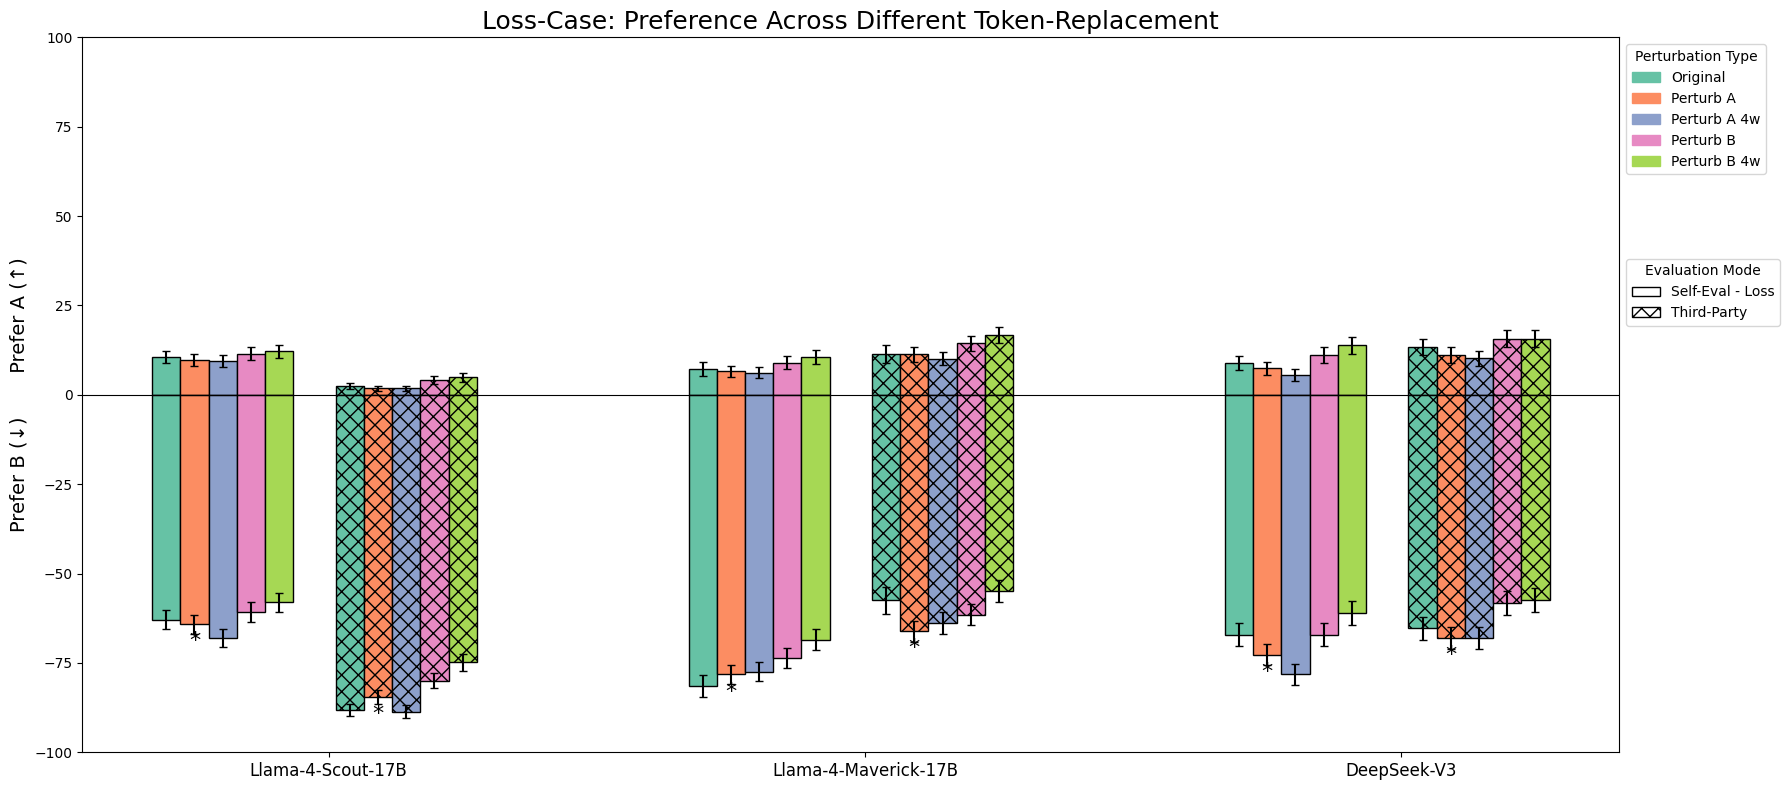

In [165]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.patches as mpatches

combined_data_stacked = data_stacked

model_names = ["Llama-4-Scout-17B","Llama-4-Maverick-17B", "DeepSeek-V3"]

perturbations = ["Original", "Perturb A", "Perturb A 4w", "Perturb B", "Perturb B 4w"]

modes = ["Self-Eval - Loss",  "Third-Party"]
conditions = ["original", "Perturb A", "Perturb A 4w", "Perturb B", "Perturb B 4w"]

colors = ["#66c2a5", "#fc8d62", "#8da0cb", "#e78ac3", "#a6d854"]
hatches = ["", "//", "xx"]

# Build bar chart
fig, ax = plt.subplots(figsize=(18, 8))
bar_width = 0.2
group_gap = 0.3
model_gap = 1.5

num_modes = 3
num_perturb = 3

offsets = {
    "Self-Eval - Loss": 0,
    "Third-Party": 1,
    "o3mini":2
}
perturb_index = {"Original": 0, "Perturb A": 1, "Perturb A 4w": 2, "Perturb B": 3, "Perturb B 4w": 4}
mode_hatch = {
    "Self-Eval - Loss": "",
    "Third-Party": "xx",
}

for i, model in enumerate(model_names):
    base_x = i * (len(modes) * len(perturbations) * bar_width + group_gap + model_gap)
    for m_idx, mode in enumerate(modes):
        for p_idx, perturb in enumerate(perturbations):
            x_pos = base_x + offsets[mode] * (len(perturbations) * bar_width + group_gap) + p_idx * bar_width
            key = f"{mode} ({perturb})" if perturb != "Original" else f"{mode} (original)"
            a_val = combined_data_stacked[key]["Prefer A"][i]
            b_val = combined_data_stacked[key]["Prefer B"][i]
            a_err = combined_data_stacked[key]["Prefer A Error"][i]
            b_err = combined_data_stacked[key]["Prefer B Error"][i]

            ax.bar(x_pos, a_val, width=bar_width, color=colors[p_idx],
                   hatch=mode_hatch[mode], edgecolor='black', yerr=a_err, capsize=3)
            ax.bar(x_pos, -b_val, width=bar_width, color=colors[p_idx],
                   hatch=mode_hatch[mode], edgecolor='black', yerr=b_err, capsize=3)

            # Add asterisk
            if mode == "Self-Eval - Loss" and perturb == "Perturb A":
                ax.text(x_pos, -b_val - 2, "*", ha='center', va='top', fontsize=16)
            elif mode == "Third-Party" and perturb == "Perturb A":
                ax.text(x_pos, -b_val - 2, "*", ha='center', va='top', fontsize=16)

# X-axis
xticks = []
xticklabels = []
for i, model in enumerate(model_names):
    base_x = i * (len(modes) * len(perturbations) * bar_width + group_gap + model_gap)
    xticks.append(base_x + (len(modes) * len(perturbations) * bar_width + group_gap) / 2)
    xticklabels.append(model)

ax.set_xticks(xticks)
ax.set_xticklabels(xticklabels, fontsize=12)

# Legends
pert_handles = [mpatches.Patch(color=colors[i], label=perturbations[i]) for i in range(len(perturbations))]
mode_handles = [
    mpatches.Patch(facecolor='white', edgecolor='black', hatch=mode_hatch[m], label=m) for m in modes
]

legend1 = ax.legend(handles=pert_handles, loc="upper left", bbox_to_anchor=(1, 1), title="Perturbation Type")
ax.add_artist(legend1)
ax.legend(handles=mode_handles, loc="upper left", bbox_to_anchor=(1, 0.7), title="Evaluation Mode")

# Y-axis labels
ax.axhline(0, color='black', linewidth=0.8)
ax.set_ylim(-100, 100)
ax.set_ylabel("Prefer B (↓)       Prefer A (↑)", fontsize=14)

plt.title("Loss-Case: Preference Across Different Token-Replacement", fontsize=18)

plt.tight_layout()
plt.show()


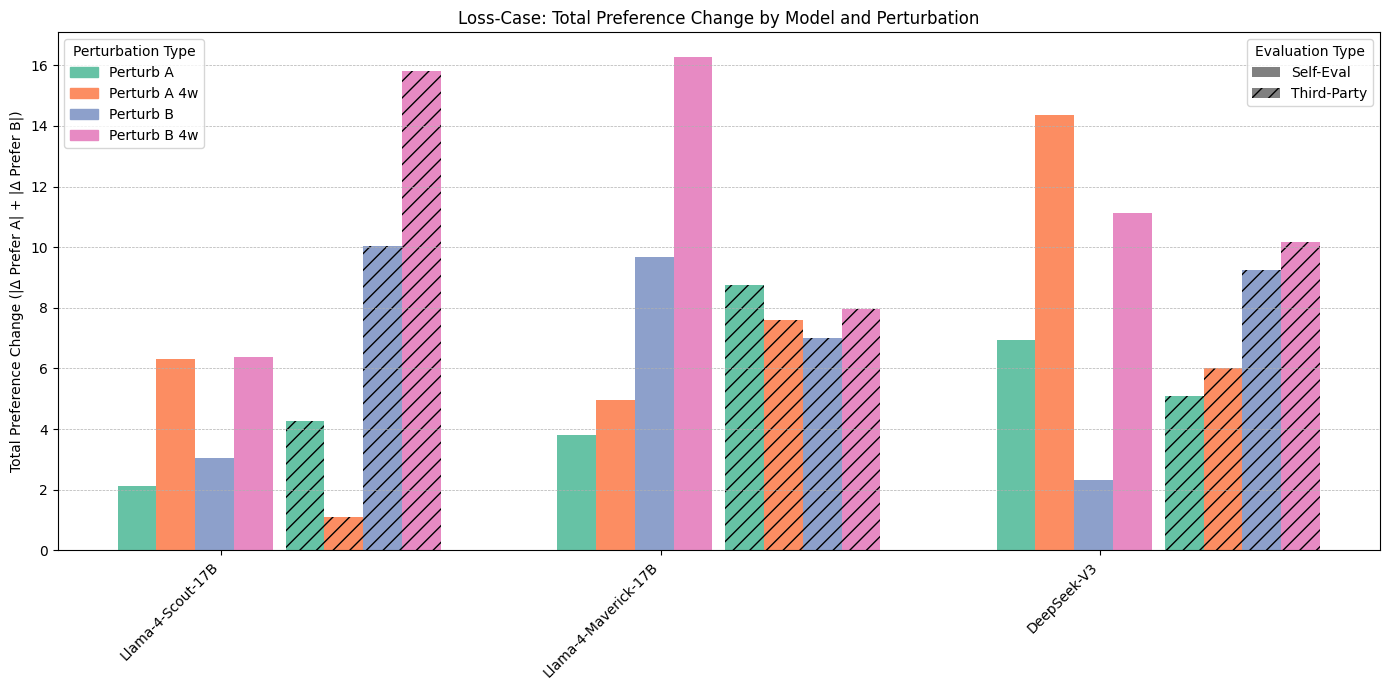

In [192]:
import matplotlib.pyplot as plt
import numpy as np

model_names = ["Llama-4-Scout-17B","Llama-4-Maverick-17B", "DeepSeek-V3"]
# Perturbations
perturbations = ["Perturb A", "Perturb A 4w", "Perturb B", "Perturb B 4w"]

# Customizable colors
colors = ["#66c2a5", "#fc8d62", "#8da0cb", "#e78ac3"]  # One color for each perturbation

# Evaluation types
eval_types = ["Self-Eval", "Third-Party"]

# Bar width and spacing
bar_width = 0.15
group_spacing = 0.4  # space between model groups
intra_group_spacing = 0.2  # small gap between Self-Eval and Third-Party

# X locations for each group
x_base = np.arange(len(model_names)) * (2 * (bar_width * 3 + intra_group_spacing) + group_spacing)

# Raw data dictionary (trimmed to only Loss versions)
data = data_stacked

fig, ax = plt.subplots(figsize=(14, 7))

for i, eval in enumerate(eval_types):
    if eval == "Self-Eval":
        original_key = f"{eval} - Loss (original)"
        key_template = f"{eval} - Loss ({{}})"
        offset_base = 0
    else:
        original_key = f"{eval} (original)"
        key_template = f"{eval} ({{}})"
        offset_base = bar_width * 3 + intra_group_spacing

    for j, (perturb, color) in enumerate(zip(perturbations, colors)):
        perturbed_key = key_template.format(perturb)

        # Calculate absolute changes
        delta_a = np.abs(np.array(data[perturbed_key]['Prefer A']) - np.array(data[original_key]['Prefer A']))
        delta_b = np.abs(np.array(data[perturbed_key]['Prefer B']) - np.array(data[original_key]['Prefer B']))
        total_change = delta_a + delta_b

        bar_pos = x_base + offset_base + j * bar_width
        ax.bar(bar_pos, total_change, width=bar_width, color=color,
               hatch='//' if eval == "Third-Party" else None,
               label=f"{eval} - {perturb}" if i == 0 else None)

# Final adjustments
ax.set_xticks(x_base + (bar_width * 3 + intra_group_spacing) / 2)
ax.set_xticklabels(model_names, rotation=45, ha='right')
ax.set_ylabel("Total Preference Change (|Δ Prefer A| + |Δ Prefer B|)")
ax.set_title("Loss-Case: Total Preference Change by Model and Perturbation")
ax.grid(axis='y', linestyle='--', linewidth=0.5)

perturb_patches = [mpatches.Patch(color=colors[i], label=perturbations[i]) for i in range(len(perturbations))]
eval_patches = [
    mpatches.Patch(facecolor='grey', label='Self-Eval'),
    mpatches.Patch(facecolor='grey', hatch='//', label='Third-Party')
]

legend1 = ax.legend(handles=perturb_patches, title="Perturbation Type", loc='upper left')
legend2 = ax.legend(handles=eval_patches, title="Evaluation Type", loc='upper right')
ax.add_artist(legend1)

plt.tight_layout()
plt.show()


In [166]:
# Suppose your data is stored in data_stacked as a dictionary (the one you shared!)
averaged_results = averaged_data = average_metrics_across_models(data_stacked)

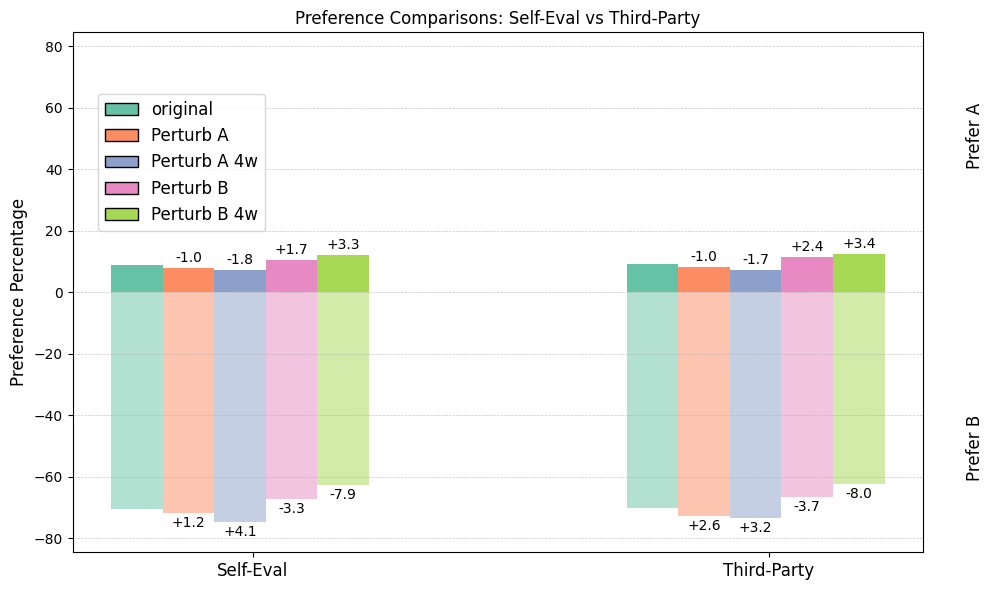

In [175]:
# Looking at the error output from notebook_cell_output_0:

# The error occurs because the code tries to access:
# averaged_results[f'Self-Eval - Loss (Original)']

# But in the data (from notebook_cell_output_1), the actual key is:
# 'Self-Eval - Loss (original)' 

# The error is due to case sensitivity - 'Original' vs 'original'

# Here's the fixed code:
import matplotlib.pyplot as plt
import numpy as np

# Configuration 
conditions = ["original", "Perturb A", "Perturb A 4w", "Perturb B", "Perturb B 4w"] # Fixed 'Original' to 'original'
colors = ["#66c2a5", "#fc8d62", "#8da0cb", "#e78ac3", "#a6d854"]
x_labels = ['Self-Eval', 'Third-Party']
x = np.arange(len(x_labels))  # [0, 1]

width = 0.1
gap = 0.15  # wider gap between condition groups

fig, ax = plt.subplots(figsize=(10, 6))

for i, condition in enumerate(conditions):
    # Data for Self-Eval - Loss and Third-Party
    self_eval_data = averaged_results[f'Self-Eval - Loss ({condition})']
    third_party_data = averaged_results[f'Third-Party ({condition})']

    # Rest of code remains the same...
    offset = - (1.5 * width + gap / 2) + i * width

    bars_a = ax.bar(x + offset, [self_eval_data['Prefer A'], third_party_data['Prefer A']],
                     width, color=colors[i], capsize=3)

    bars_b = ax.bar(x + offset, [-self_eval_data['Prefer B'], -third_party_data['Prefer B']],
                     width, color=colors[i], alpha=0.5, capsize=3)

    if condition in ["Perturb A", "Perturb B", "Perturb A 4w", "Perturb B 4w"]:  # Added 4w conditions
        orig_self_eval = averaged_results['Self-Eval - Loss (original)'] # Fixed case here too
        orig_third_party = averaged_results['Third-Party (original)'] # And here

        diff_a_self = self_eval_data['Prefer A'] - orig_self_eval['Prefer A']
        diff_a_third = third_party_data['Prefer A'] - orig_third_party['Prefer A']
        diff_b_self = self_eval_data['Prefer B'] - orig_self_eval['Prefer B']
        diff_b_third = third_party_data['Prefer B'] - orig_third_party['Prefer B']

        ax.text(x[0] + offset, self_eval_data['Prefer A'] + 1, f'{diff_a_self:+.1f}', ha='center', va='bottom', fontsize=10)
        ax.text(x[1] + offset, third_party_data['Prefer A'] + 1, f'{diff_a_third:+.1f}', ha='center', va='bottom', fontsize=10)
        ax.text(x[0] + offset, -self_eval_data['Prefer B'] - 1, f'{diff_b_self:+.1f}', ha='center', va='top', fontsize=10)
        ax.text(x[1] + offset, -third_party_data['Prefer B'] - 1, f'{diff_b_third:+.1f}', ha='center', va='top', fontsize=10)

ax.set_xticks(x)
ax.set_xticklabels(x_labels, fontsize=12)
ax.set_ylabel('Preference Percentage', fontsize=12)
ax.set_title('Preference Comparisons: Self-Eval vs Third-Party', fontsize=12)

from matplotlib.patches import Patch
legend_elements_conditions = [Patch(facecolor=colors[i], edgecolor='k', label=conditions[i]) for i in range(len(conditions))]
ax.legend(handles=legend_elements_conditions, loc='center left', bbox_to_anchor=(0.02, 0.75), fontsize=12)

ax.text(1.05, 0.8, 'Prefer A', transform=ax.transAxes, fontsize=12, rotation=90, va='center')
ax.text(1.05, 0.2, 'Prefer B', transform=ax.transAxes, fontsize=12, rotation=90, va='center')

max_pref = max(max([averaged_results[f'Self-Eval - Loss ({c})']['Prefer A'] for c in conditions]),
                max([averaged_results[f'Third-Party ({c})']['Prefer A'] for c in conditions]),
                max([averaged_results[f'Self-Eval - Loss ({c})']['Prefer B'] for c in conditions]),
                max([averaged_results[f'Third-Party ({c})']['Prefer B'] for c in conditions]))
ax.set_ylim(-max_pref - 10, max_pref + 10)
ax.grid(axis='y', linestyle='--', linewidth=0.5, alpha=0.7)

plt.tight_layout()
plt.show()


In [181]:

def track_prediction_changes_self_eval_percentage(pref_original, *pref_lists, perturbation_names=None):
    # Validate inputs
    if not pref_lists:
        raise ValueError("Must provide at least one perturbation list")
    if perturbation_names and len(perturbation_names) != len(pref_lists):
        raise ValueError("Number of perturbation names must match number of perturbation lists")

    # Use default names if none provided
    if not perturbation_names:
        perturbation_names = [f'Perturb {i+1}' for i in range(len(pref_lists))]

    # Helper to build lookup for original predictions
    def build_lookup(data):
        lookup = {}
        for r in data:
            key = (r['evaluator'], r['evaluatee'], r['pid'])
            vote = classify_vote(r['forward_comparison'], r['backward_comparison'])
            lookup[key] = vote
        return lookup

    # Build original predictions lookup
    original_lookup = build_lookup(pref_original)

    # Function to count transitions per initial state
    def count_transitions(data):
        transitions = defaultdict(lambda: defaultdict(int))
        for r in data:
            key = (r['evaluator'], r['evaluatee'], r['pid'])
            orig_vote = original_lookup.get(key, 'amb')
            new_vote = classify_vote(r['forward_comparison'], r['backward_comparison'])
            transitions[orig_vote][new_vote] += 1
        return transitions

    # Count transitions for each perturbation
    all_transitions = [count_transitions(perturb_data) for perturb_data in pref_lists]

    # Build a DataFrame for each perturbation
    all_initial_states = ['A', 'B', 'amb']
    all_end_states = ['A', 'B', 'amb']
    result_dict = {}

    for perturb_name, transitions in zip(perturbation_names, all_transitions):
        # Dynamically build the column names for each initial state
        columns = []
        for s1 in all_initial_states:
            for s2 in all_end_states:
                columns.append(f"{s1}→{s2}")

        df = pd.DataFrame(0, index=all_initial_states, columns=columns)
        for start in all_initial_states:
            total = sum(transitions[start].values())
            if total > 0:
                for end in all_end_states:
                    count = transitions[start][end]
                    df.loc[start, f"{start}→{end}"] = (count / total) * 100
        result_dict[perturb_name] = df.round(2)

    # Combine into a multi-level column DataFrame
    combined_df = pd.concat(result_dict.values(), axis=1, keys=result_dict.keys())

    return combined_df



In [ ]:
# Example usage track_prediction_changes_third_party_percentage(pref_original, *pref_lists, perturbation_names=None):
change_summary_self = track_prediction_changes_self_eval_percentage(
    preference_results,
    pref_synonym_auto_quality_harmful,
    pref_synonym_auto_other_quality_harmful,
    pref_synonym_auto_4w_small_quality_harmful,
    pref_synonym_auto_4w_small_other_quality_harmful,
    perturbation_names=["Perturb A", "Perturb B", "Perturb A 4w", "Perturb B 4w"]
)

In [ ]:
# Example usage
change_summary_third = track_prediction_changes_third_party_percentage(
    pref_results_third_party_eval_original_harmful,
    pref_third_party_all_models_synonym_auto_wrong_quality,
    pref_third_party_all_models_synonym_auto_right_quality,
    pref_third_party_all_models_synonym_auto_4w_small_wrong_quality,
    pref_third_party_all_models_synonym_auto_4w_small_right_quality,
    perturbation_names=["Perturb A", "Perturb B", "Perturb A 4w", "Perturb B 4w"]
)



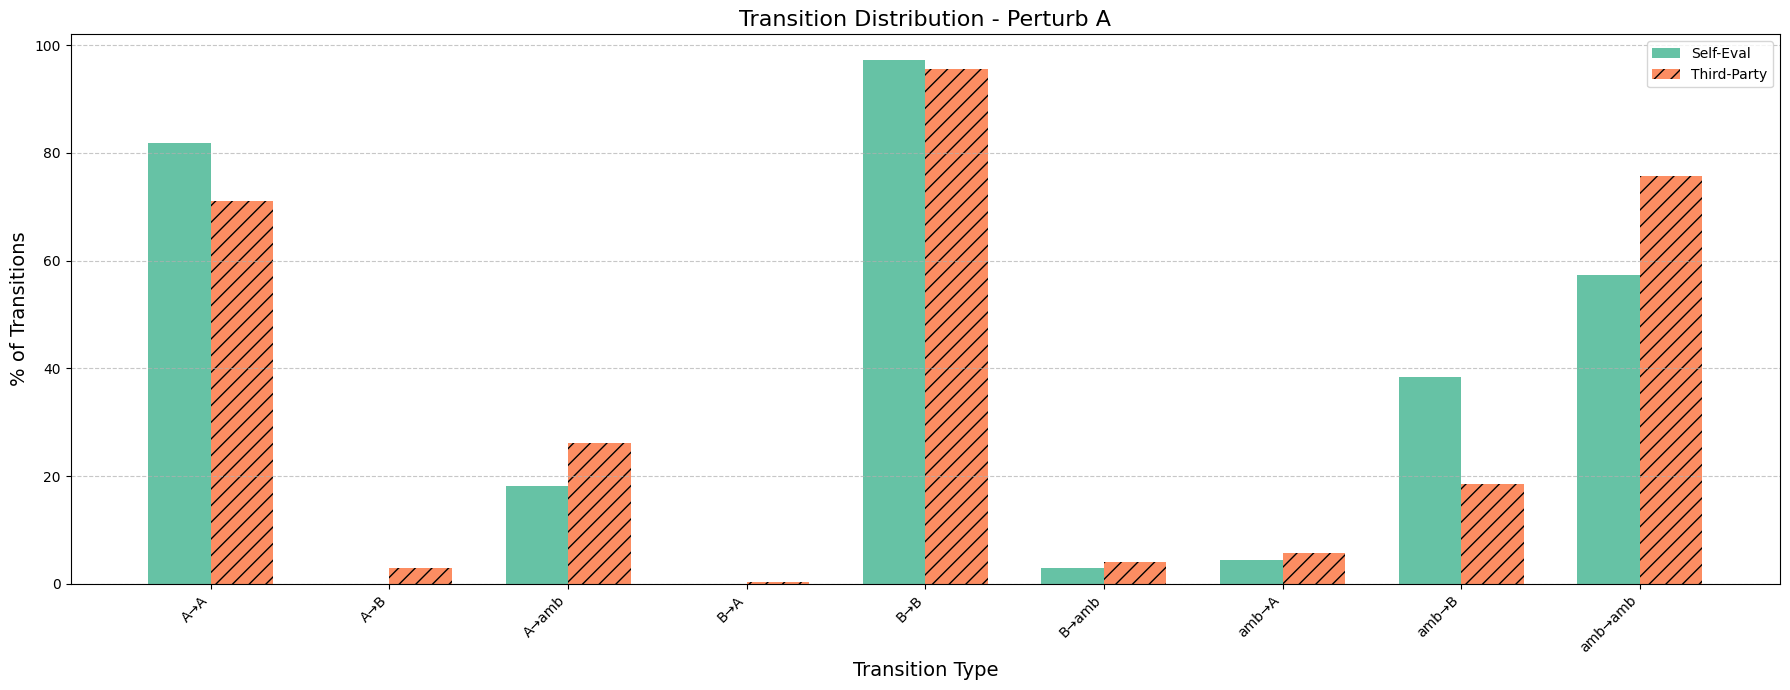

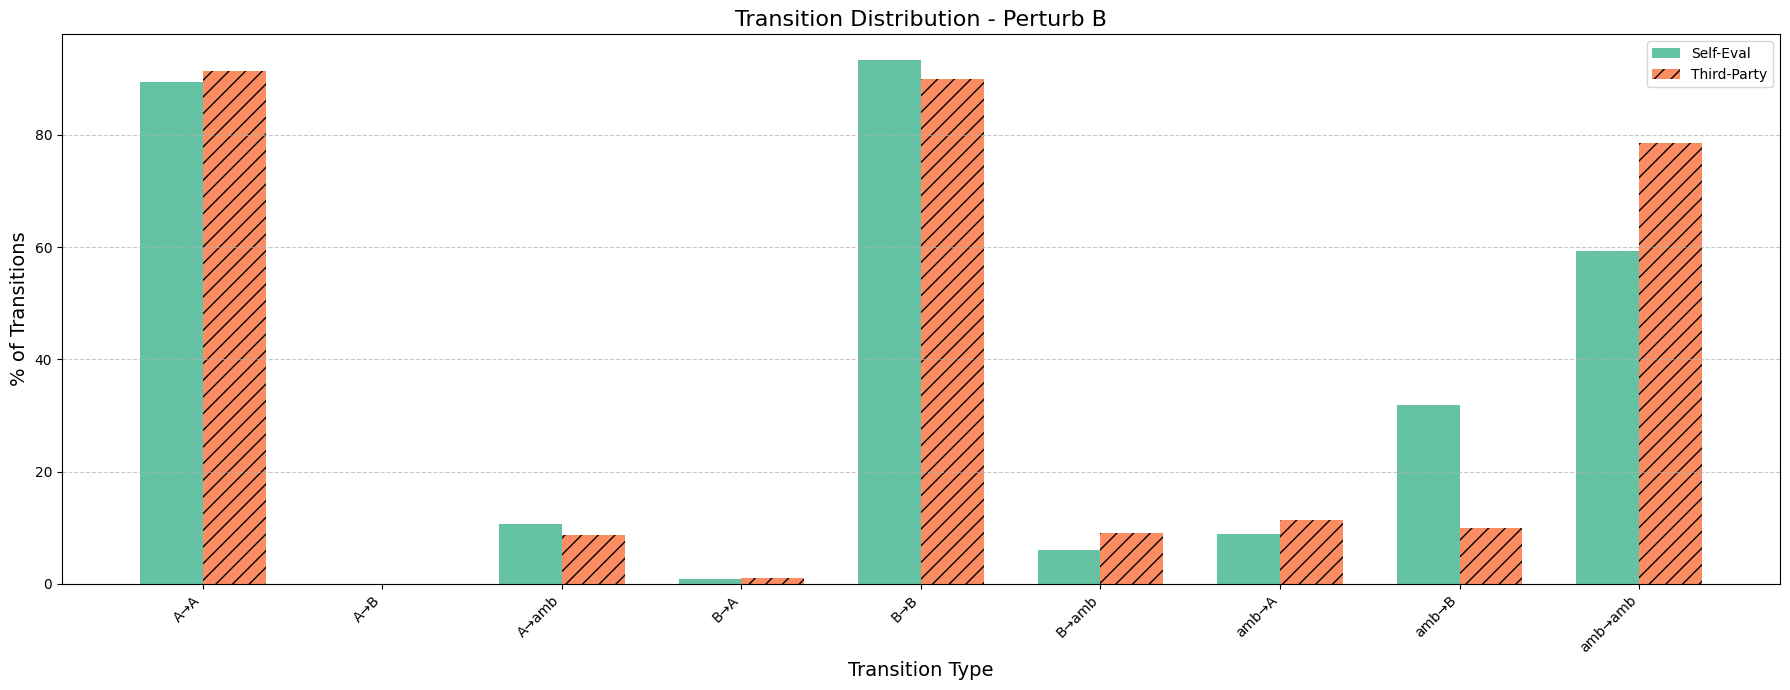

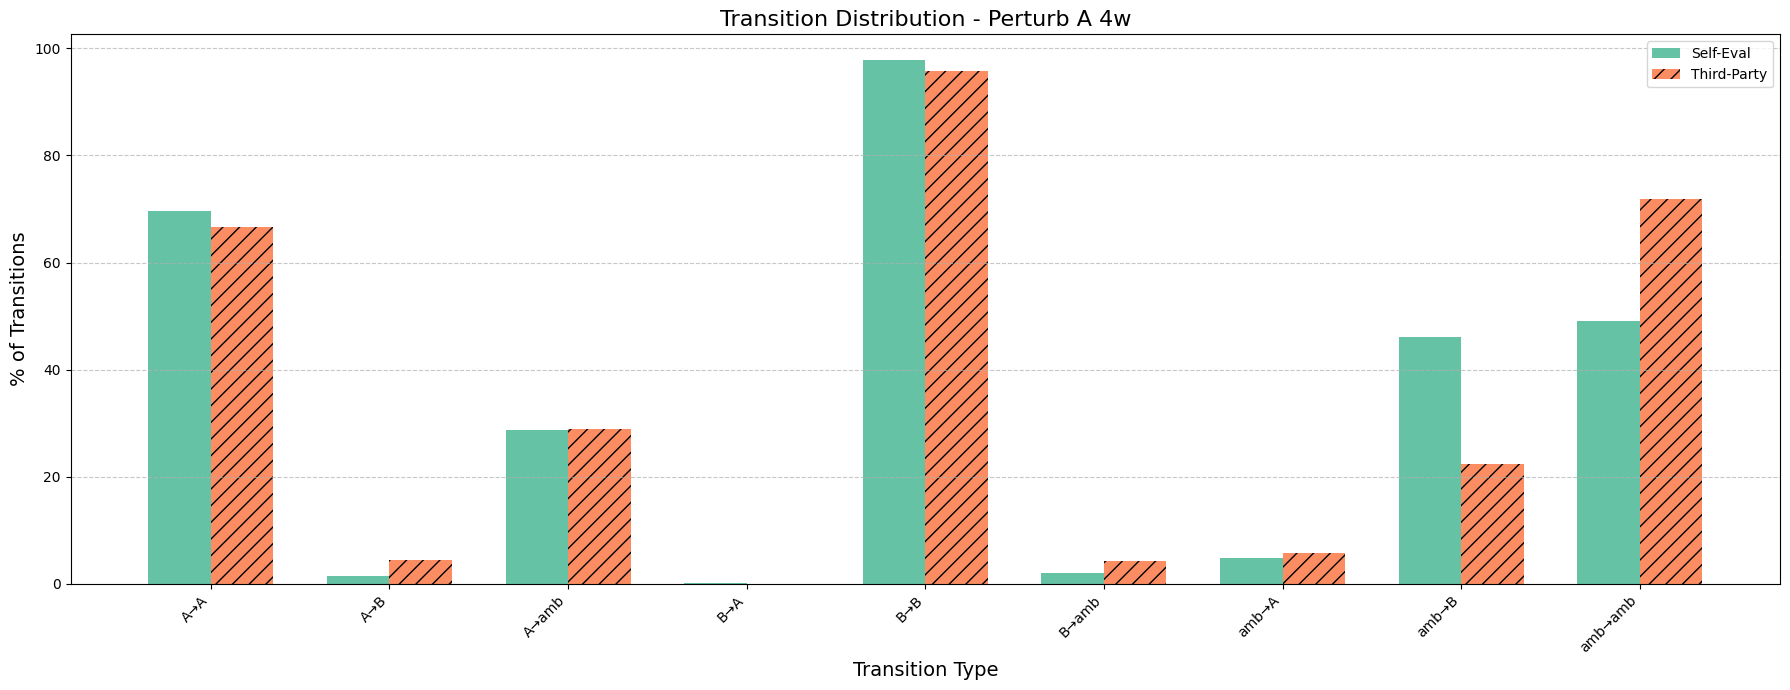

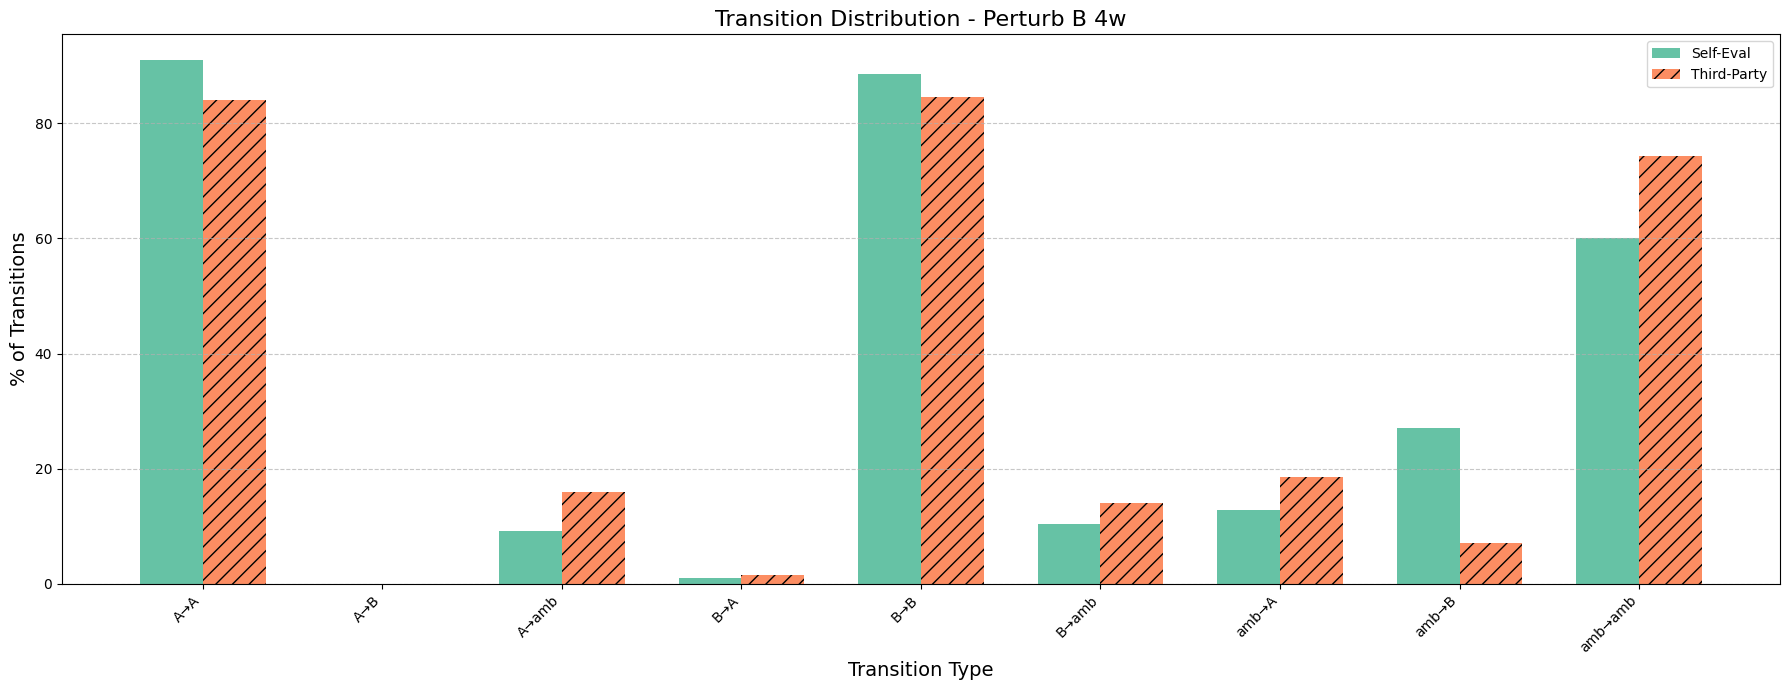

In [185]:
# Loop for all conditions
for condition in ["Perturb A", "Perturb B", "Perturb A 4w", "Perturb B 4w"]:
    plot_transition_comparison(
        change_summary_self[condition],
        change_summary_third[condition],
        condition
    )


## WinCase

In [200]:
third_party_original_loss = compute_third_party_accuracy(preference_results_other_wrong, pref_results_third_party_eval_original_harmful, harmful=False, judge_models=judge_models)
third_party_pref_a = third_party_original_loss['Prefer A (%)'].tolist()
third_party_pref_b = third_party_original_loss['Prefer B (%)'].tolist()
third_party_pref_a_error = third_party_original_loss['Prefer A Error (%)'].tolist()
third_party_pref_b_error = third_party_original_loss['Prefer B Error (%)'].tolist()

In [201]:
data_stacked_original = compute_preference_percentages_with_error(preference_results,
                                                                  preference_results_other_wrong,
                                                                  third_party_pref_a, third_party_pref_a_error,
                                                                  third_party_pref_b, third_party_pref_b_error,
                                                                  # prefer_a_third_party_o3mini, error_a_third_party_o3mini,
                                                                  # prefer_b_third_party_o3mini, error_b_third_party_o3mini,
                                                                  "original")

In [202]:
third_party_token_loss = compute_third_party_accuracy(pref_synonym_auto_quality_beneficial, pref_third_party_all_models_synonym_auto_wrong_quality, harmful=False, judge_models=judge_models)
third_party_pref_a = third_party_token_loss['Prefer A (%)'].tolist()
third_party_pref_b = third_party_token_loss['Prefer B (%)'].tolist()
third_party_pref_a_error = third_party_token_loss['Prefer A Error (%)'].tolist()
third_party_pref_b_error = third_party_token_loss['Prefer B Error (%)'].tolist()

In [203]:
data_stacked_perturb_A = compute_preference_percentages_with_error(pref_synonym_auto_quality_harmful,
                                                                  pref_synonym_auto_quality_beneficial,
                                                                  third_party_pref_a, third_party_pref_a_error,
                                                                  third_party_pref_b, third_party_pref_b_error,
                                                                  # prefer_a_third_party_o3mini, error_a_third_party_o3mini,
                                                                  # prefer_b_third_party_o3mini, error_b_third_party_o3mini,
                                                                  "Perturb A")

In [204]:
third_party_token_right_loss = compute_third_party_accuracy(pref_synonym_auto_other_quality_beneficial, pref_third_party_all_models_synonym_auto_right_quality, harmful=False, judge_models=judge_models)
third_party_pref_a = third_party_token_right_loss['Prefer A (%)'].tolist()
third_party_pref_b = third_party_token_right_loss['Prefer B (%)'].tolist()
third_party_pref_a_error = third_party_token_right_loss['Prefer A Error (%)'].tolist()
third_party_pref_b_error = third_party_token_right_loss['Prefer B Error (%)'].tolist()



In [205]:
data_stacked_perturb_B = compute_preference_percentages_with_error(pref_synonym_auto_other_quality_harmful,
                                                                  pref_synonym_auto_other_quality_beneficial,
                                                                  third_party_pref_a, third_party_pref_a_error,
                                                                  third_party_pref_b, third_party_pref_b_error,
                                                                  "Perturb B")

In [ ]:
third_party_token_loss = compute_third_party_accuracy(pref_synonym_auto_4w_small_quality_harmful, pref_third_party_all_models_synonym_auto_4w_small_wrong_quality, harmful=True, judge_models=judge_models)
third_party_pref_a = third_party_token_loss['Prefer A (%)'].tolist()
third_party_pref_b = third_party_token_loss['Prefer B (%)'].tolist()
third_party_pref_a_error = third_party_token_loss['Prefer A Error (%)'].tolist()
third_party_pref_b_error = third_party_token_loss['Prefer B Error (%)'].tolist()

In [ ]:
data_stacked_perturb_A_4w = compute_preference_percentages_with_error(pref_synonym_auto_4w_small_quality_harmful,
                                                                  pref_synonym_auto_4w_small_quality_harmful,
                                                                  third_party_pref_a, third_party_pref_a_error,
                                                                  third_party_pref_b, third_party_pref_b_error,
                                                                  # prefer_a_third_party_o3mini, error_a_third_party_o3mini,
                                                                  # prefer_b_third_party_o3mini, error_b_third_party_o3mini,
                                                                  "Perturb A 4w")

## Token-Replacement (right) 4 Words

In [ ]:
third_party_token_loss = compute_third_party_accuracy(pref_synonym_auto_4w_small_other_quality_harmful, pref_third_party_all_models_synonym_auto_4w_small_right_quality, harmful=True, judge_models=judge_models)
third_party_pref_a = third_party_token_loss['Prefer A (%)'].tolist()
third_party_pref_b = third_party_token_loss['Prefer B (%)'].tolist()
third_party_pref_a_error = third_party_token_loss['Prefer A Error (%)'].tolist()
third_party_pref_b_error = third_party_token_loss['Prefer B Error (%)'].tolist()

In [ ]:
data_stacked_perturb_B_4w = compute_preference_percentages_with_error(pref_synonym_auto_4w_small_other_quality_harmful,
                                                                  pref_synonym_auto_4w_small_other_quality_harmful,
                                                                  third_party_pref_a, third_party_pref_a_error,
                                                                  third_party_pref_b, third_party_pref_b_error,
                                                                  # prefer_a_third_party_o3mini, error_a_third_party_o3mini,
                                                                  # prefer_b_third_party_o3mini, error_b_third_party_o3mini,
                                                                  "Perturb B 4w")

# Analysis of Corrupt Data

In [206]:
with open(".\quality\quality_responses.json", 'r') as file:
    responses = json.load(file)

In [207]:

model_names = [
    "Meta-Llama-3.1-8B-Instruct-Turbo",
    "Qwen2.5-7B-Instruct-Turbo",
    "Llama-4-Scout-17B-16E-Instruct",
    "Llama-4-Maverick-17B-128E-Instruct-FP8",
    "DeepSeek-V3"
]

In [210]:
import json
import re
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np

match_threshold = 0.3

# Load the model names
model_names = [
    "Meta-Llama-3.1-8B-Instruct-Turbo",
    "Qwen2.5-7B-Instruct-Turbo",
    "Llama-4-Scout-17B-16E-Instruct",
    "Llama-4-Maverick-17B-128E-Instruct-FP8",
    "DeepSeek-V3"
]

def extract_options(questions):
    """Extract options A, B, C, D from the questions text."""
    options = {}
    
    # Find each option using regex to handle both newline types
    import re
    
    # Pattern to match options with their content
    patterns = {
        'A': r'\(A\)(.*?)(?=\s*\(B\))',
        'B': r'\(B\)(.*?)(?=\s*\(C\))',
        'C': r'\(C\)(.*?)(?=\s*\(D\))',
        'D': r'\(D\)(.*)'  # Match everything after (D)
    }
    
    for key, pattern in patterns.items():
        match = re.search(pattern, questions, re.DOTALL)
        if match:
            # Clean up the matched text
            option_text = match.group(1).strip()
            # Remove any leading/trailing whitespace and newlines
            option_text = ' '.join(option_text.split())
            options[key] = option_text
    
    return options



def find_best_matching_option(reason, options, model):
    """Find the best matching option for a given reason using sentence transformers."""
    # Encode the reason and all options
    reason_embedding = model.encode([reason])
    option_embeddings = model.encode(list(options.values()))
    
    # Calculate similarities
    similarities = cosine_similarity(reason_embedding, option_embeddings)[0]
    
    # Get the best matching option and its similarity score
    best_match_idx = np.argmax(similarities)
    best_match_option = list(options.keys())[best_match_idx]
    
    # Get second best similarity score
    similarities_copy = similarities.copy()
    similarities_copy[best_match_idx] = -np.inf  # Remove best score
    second_best_score = np.max(similarities_copy)
    
    # Return both the best option and whether it's significantly better
    is_significant = similarities[best_match_idx] - second_best_score >= match_threshold
    return best_match_option, is_significant

def analyze_responses(responses_file):
    # Load the sentence transformer model
    st_model = SentenceTransformer('all-MiniLM-L6-v2')
    
    # Load responses
    with open(responses_file, 'r') as f:
        responses = json.load(f)
    
    mismatches = []
    
    # Process each record
    for record in responses:
        questions = record.get('questions', '')
        pid = record.get('pid', '')
        
        # Extract options from questions
        options = extract_options(questions)
        if not options:
            continue
            
        # Process each model's output
        for model_name in model_names:
            output_label_key = f"{model_name}_output_label"
            reason_key = f"{model_name}_reason"
            
            model_output = record.get(output_label_key)
            model_reason = record.get(reason_key)
            
            if not model_output or not model_reason:
                continue
                
            # Find best matching option based on reason
            matched_option, is_significant = find_best_matching_option(model_reason, options, st_model)
            
            # Only consider mismatch if the best match is significantly better
            if matched_option != model_output and is_significant:
                mismatches.append({
                    'pid': pid,
                    'model_name': model_name,
                    'model_output_label': model_output,
                    'matched_option': matched_option,
                    'reason': model_reason,
                    'options': options
                })
    
    return mismatches



In [211]:
responses_file = "./quality/quality_responses.json"
mismatches = analyze_responses(responses_file)

# Print results
print(f"\nFound {len(mismatches)} mismatches between model outputs and their reasoning:")
for mismatch in mismatches:
    print(f"\nPID: {mismatch['pid']}")
    print(f"Model: {mismatch['model_name']}")
    print(f"Model Output Label: {mismatch['model_output_label']}")
    print(f"Matched Option: {mismatch['matched_option']}")
    print(f"Reason: {mismatch['reason']}")
    print("Options:")
    for opt, text in mismatch['options'].items():
        print(f"({opt}) {text}")
    print("-" * 80)


Found 79 mismatches between model outputs and their reasoning:

PID: 63523_STSHLFEA_3_0
Model: Qwen2.5-7B-Instruct-Turbo
Model Output Label: B
Matched Option: D
Reason: The Oans' unusual advantage is that they have eyes that can 'cut the night,' as mentioned in the text.
Options:
(A) They have the human's fire weapons.
(B) They emit flames.
(C) The strength of their arms.
(D) Their eyes cut the night.
--------------------------------------------------------------------------------

PID: 63401_ZCP5ZDGL_6_0
Model: Meta-Llama-3.1-8B-Instruct-Turbo
Model Output Label: B
Matched Option: C
Reason: The Interstellar Cosmography Society members report that the asteroid will not be in the space lanes for 3 years, so they need to wait that long to leave, making option B the correct reason.
Options:
(A) They are afraid of being tempted by the wild women.
(B) They want to get back to Universal so that they can report that Johnathan is alive.
(C) They have already been on the asteroid a week longer